# Modélisation de l'energy

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tabulate import tabulate
from utils import display_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pmdarima as pm
import pickle

In [21]:
df = pd.read_csv('energy_antananarivo_cleaned.csv')

In [22]:
# Modification du type de l'objet object en datetime
df['date_dep_dmd'] = pd.to_datetime(df['date_dep_dmd'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_dep_dmd  288 non-null    datetime64[ns]
 1   tot_nb_dmd    288 non-null    int64         
 2   tot_energy    288 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 6.9 KB


In [23]:
# Suppression de la colonne 'tot_energy'
df = df.drop('tot_energy', axis=1)
df.set_index('date_dep_dmd', inplace=True)
df.head(1)

,tot_energy
date_dep_dmd,
2000-01-01,779.932667


In [24]:
# Vérification des valeurs manquantes
df.isnull().sum()

tot_energy    0
dtype: int64

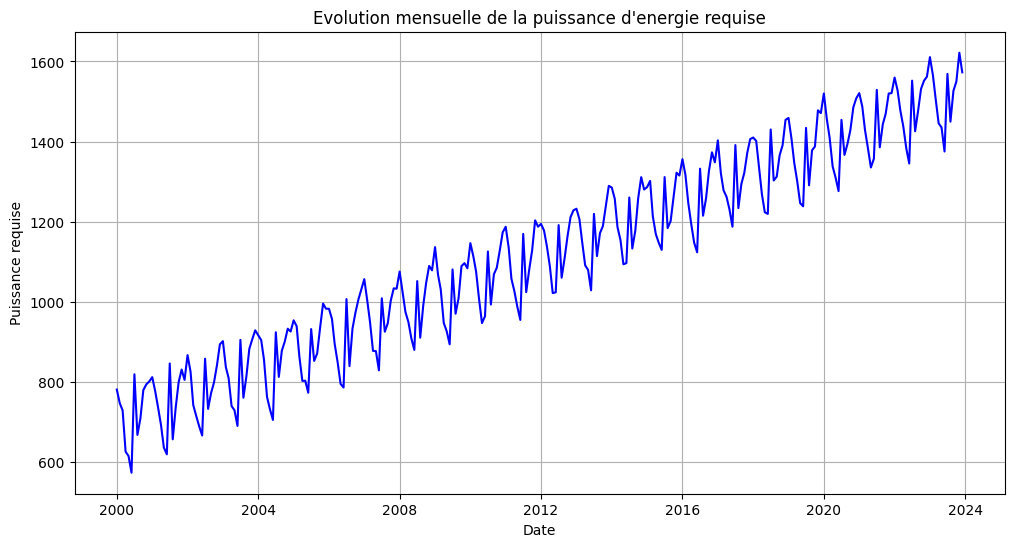

In [25]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df.tot_energy, color='blue')
plt.title('Evolution mensuelle de la puissance d\'energie requise')
plt.xlabel('Date')
plt.ylabel('Puissance requise')
plt.grid(True)
plt.show()

## Stationnarité de données

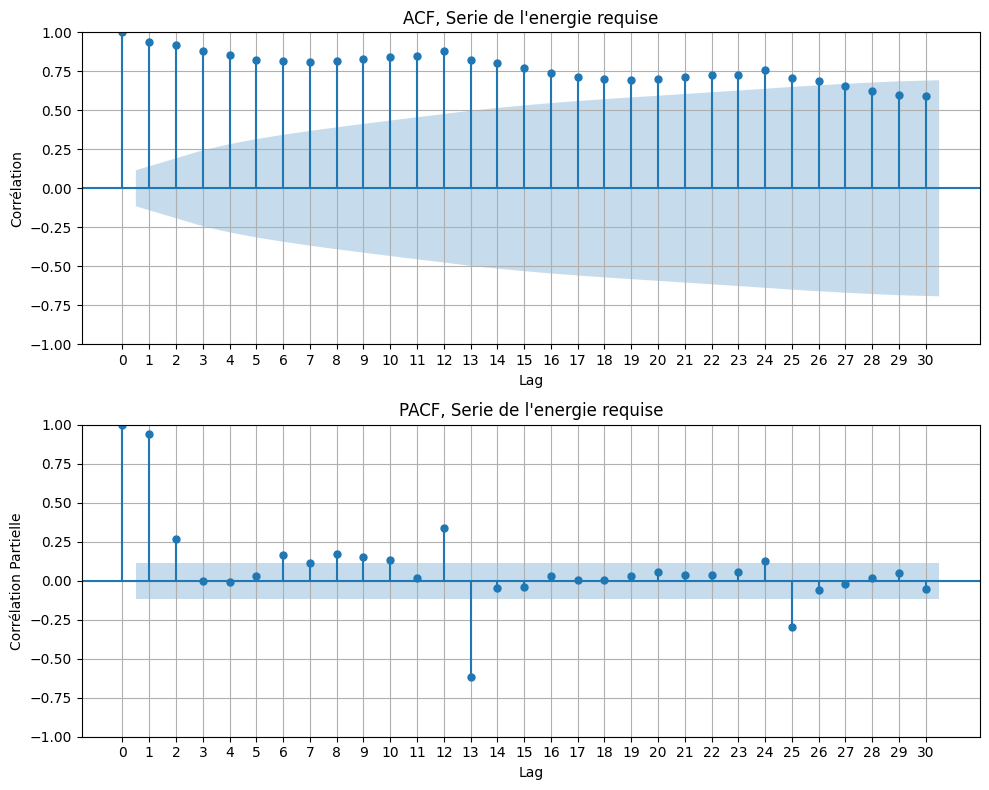

In [26]:
# Création des subplots 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

# Traçage l'ACF
plot_acf(df.tot_energy, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF, Serie de l\'energie requise')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajustement des graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0,31,1))

# Traçage PACF
plot_pacf(df.tot_energy, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF, Serie de l\'energie requise')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

# Ajustement les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0,31,1))

# Ajustement les subplots
plt.tight_layout()

plt.show()

In [27]:
# Test de Dickey-Fuller augmenté
result = adfuller(df)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | 0.24460492952109503           |
| P-valeur       | 0.9746552694182085            |
| Conclusion     | La serie est non stationnaire |


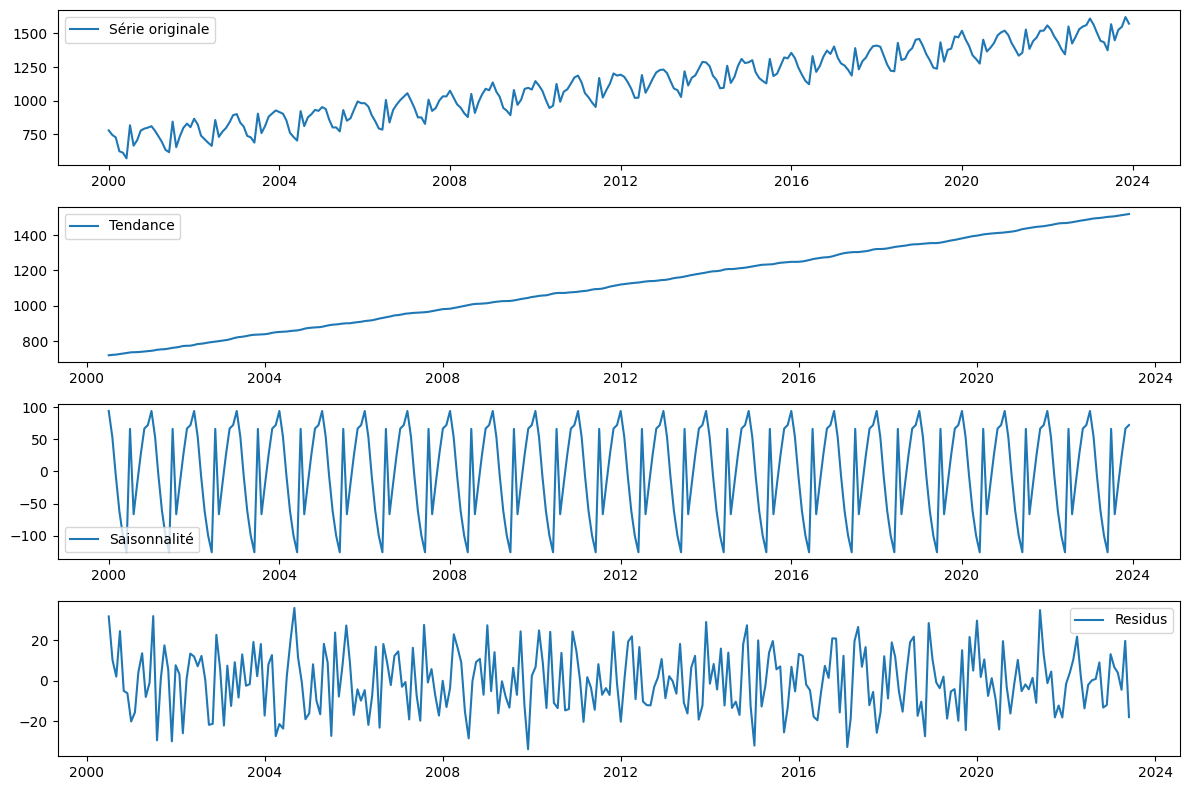

In [28]:
# Decompostion saisonnière
decomposition = seasonal_decompose(df.tot_energy, model='additive')

# Extraction des composantes de la decomposotion
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Affichage des composantes de la décomposition
plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(df.tot_energy, label='Série originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residus')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

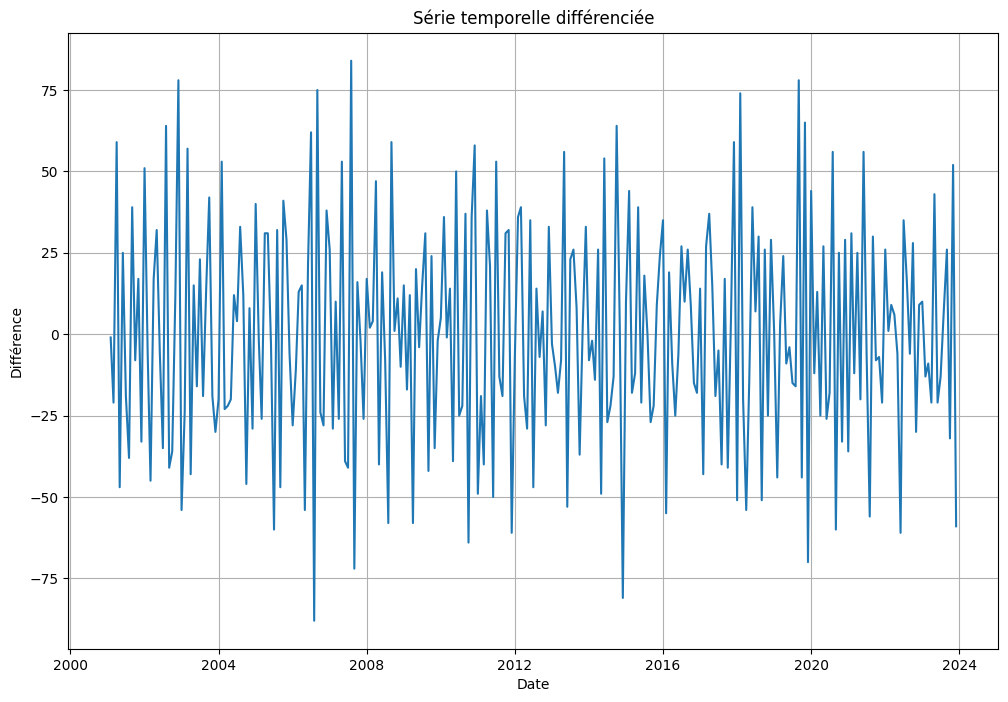

In [29]:
## Différenciation de données
differenced = df.tot_energy.diff().dropna()

# Differenciation saisonnière 
differenced = differenced.diff(12).dropna()

# Afficher la série différenciée
plt.figure(figsize=(12,8))
plt.plot(differenced)
plt.title('Série temporelle différenciée')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()

In [30]:
# Test de Dickey-Fuller augmenté
result = adfuller(differenced)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -8.721612919153488        |
| P-valeur       | 3.373590506922749e-14     |
| Conclusion     | La série est stationnaire |


In [31]:
# Utilisation de l'auto_arima pour trouver le meilleur modèle ARIMA
train = differenced[:-15]
test = differenced[-15:]

model =  pm.auto_arima(train, seasonal=True, m=12)

print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  260
Model:             SARIMAX(5, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -1127.826
Date:                              Tue, 19 Mar 2024   AIC                           2271.653
Time:                                      10:30:30   BIC                           2300.138
Sample:                                  02-01-2001   HQIC                          2283.104
                                       - 09-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7849      0.063    -12.394      0.000      -0.909      -0.661
ar.L2         -0.64

modèle optimal: SARIMAX(5, 0, 0)x(1, 0, [1], 12)

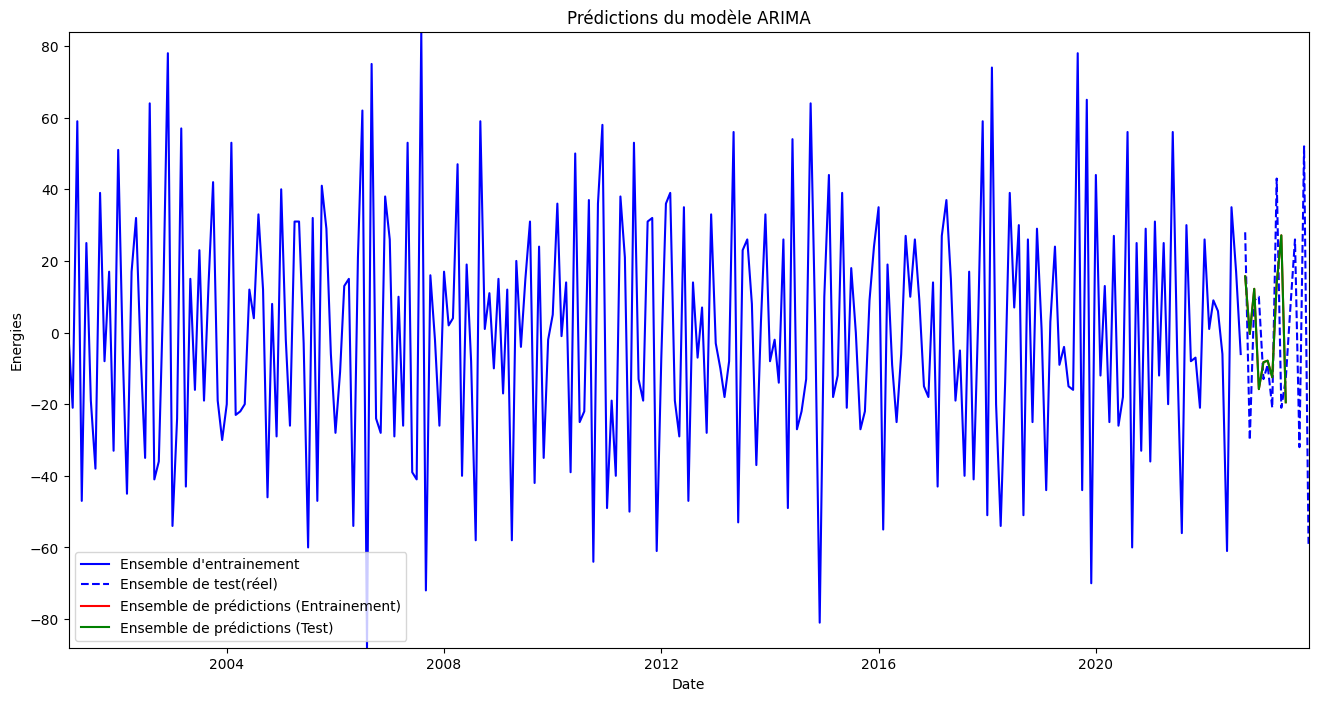

In [33]:
# Prédiction sur l'ensemble d'entrainement
train_prediction = model.predict(start=train.index[0], end=train.index[-1])

# Prédiction sur l'ensemble de test
test_prediction = model.predict(start=test.index[0], end=test.index[-1])

# Traçage des predictions et les données réels avec les courbes collées.
plt.figure(figsize=(16,8))
plt.plot(train.index, train.values, label='Ensemble d\'entrainement', color='blue')
plt.plot(test.index, test.values, label='Ensemble de test(réel)', linestyle='--', color='blue')
plt.plot(train_prediction.index, train_prediction.values, label='Ensemble de prédictions (Entrainement)', color='red')
plt.plot(test_prediction.index, test_prediction.values, label='Ensemble de prédictions (Test)', color='green')

# Définition des limites des axes x et y pour une continuté visuelle.
plt.xlim(train.index[0], test.index[-1])
plt.ylim(min(train.min(), test.min()), max(train.max(), test.max()))

plt.xlabel('Date')
plt.ylabel('Energies')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

In [36]:
# Prédictions sur l'ensemble des données de test
n_periods = len(test)
predictions ,confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Mesures de performances sur l'ensemble de test
test_mae = mean_absolute_error(test, predictions)
test_mse = mean_squared_error(test, predictions)
test_rmse = mean_squared_error(test, predictions, squared=False)
test_r2 = r2_score(test, predictions)

# Création d'un Dataframe pour afficher les mesures de performance
perf_df = pd.DataFrame({
    'Métriques:': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble de test:': [test_mae, test_mse, test_rmse, test_r2]
})

perf_df

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Métriques:,Ensemble de test:
0,MAE,22.792074
1,MSE,828.120411
2,RMSE,28.777081
3,R²,0.038093


In [40]:
# SARIMAX(5, 0, 0)x(1, 0, [1], 12)
model_sarima = SARIMAX(df, order=(5, 0, 0), seasonal_order=(2, 0, [1], 12))
model_sarima_fit = model_sarima.fit()

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05605D+02    |proj g|=  1.35289D+03

At iterate    5    f=  5.49999D+00    |proj g|=  4.06504D-01

At iterate   10    f=  5.34201D+00    |proj g|=  1.68629D-02

At iterate   15    f=  5.29475D+00    |proj g|=  1.80244D-02

At iterate   20    f=  4.84246D+00    |proj g|=  6.97700D-02

At iterate   25    f=  4.78135D+00    |proj g|=  4.36731D-02

At iterate   30    f=  4.77679D+00    |proj g|=  1.01124D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     63      1     0     0   2.998D-02   4.777D+00
  F =   4.7767900214745600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [41]:
# Utiliser les paramètres internes du modèle pour faire des prédictions
predictions = model_sarima_fit.predict(start=len(df))

In [42]:
model_sarima_fit.forecast(12)

2024-01-01    1637.550174
2024-02-01    1599.288189
2024-03-01    1543.217700
2024-04-01    1487.999402
2024-05-01    1475.011261
2024-06-01    1420.655713
2024-07-01    1599.525704
2024-08-01    1489.431834
2024-09-01    1561.806719
2024-10-01    1581.315135
2024-11-01    1649.644801
2024-12-01    1602.625243
Freq: MS, Name: predicted_mean, dtype: float64

In [43]:
# Enregistrement de la fonction dans un fichier pickle
with open('model_sarima_energy_fit.pkl', 'wb') as pkl_file:
    pickle.dump(model_sarima_fit, pkl_file)